In [1]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error

import cv2 as cv

You should submit before the deadline a **TP_ParticleFilter_firstname1-surname1_firstname2-surname2.zip** containing:
- The completed .ipynb notebook
- The completed particle_filter.py file

You do not need to attach the data nor the outputs (images and videos) as we must be able to regenerate the output by running your notebook.

# Particle filter for color-based object tracking

In this practical work, you will implement a particle filter-based single object tracking approach based on the "color-based probabilistic tracking" framework discussed in the lecture slides (starting from slide 70). The notebook guides you to implement the appearance model, the state propagation model, the particle filter itself, to finally run the tracker on videos.

### Extracting the template patch

We will first use the example video 'data/cows.avi'. The first frame in the video is saved in 'data/cows_first_frame.png' and we load it first below:

In [2]:
data_dir = 'data'

In [3]:
zeroth_frame_filename = os.path.join(data_dir, 'cows_first_frame.png')
zeroth_frame = cv.imread(zeroth_frame_filename)

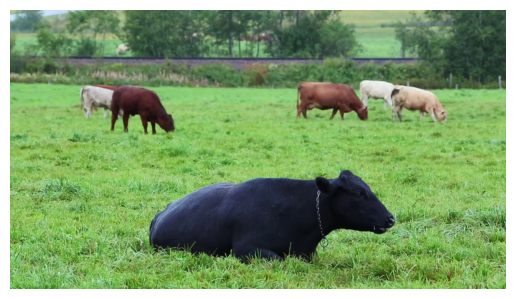

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal') 
ax.imshow(cv.cvtColor(zeroth_frame, cv.COLOR_BGR2RGB))     
plt.grid(False)
plt.axis('off')
plt.show()

The single object tracker tracks an object manually defined by a template patch that we have to extract from the first frame. Below I have defined a bounding box width, height, center coordinates $x,y$ so as to track the head of the brown cow. You can change the bounding box parameters to track another object if you want. To help place the bounding box, you can visualize the bounding box on top of the frame in the plot below.

In [5]:
# Template patch
template_W = 100
template_H = 100
template_x = 600
template_y = 430

# Bounding box in [x1,y1,x2,y2] format:
template_bb = np.array([template_x-template_W//2,template_y-template_H//2,
                        template_x+template_W//2,template_y+template_H//2])

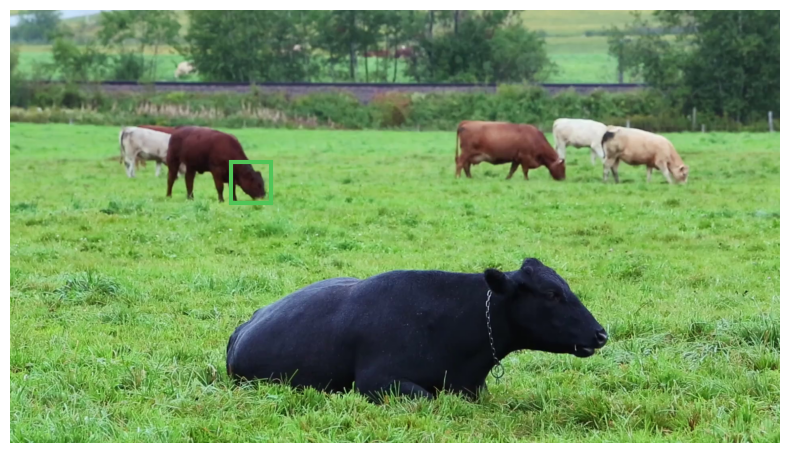

In [6]:
fig = plt.figure(figsize=(10, 10*zeroth_frame.shape[0]/zeroth_frame.shape[1]))
ax = fig.add_subplot(111, aspect='equal')   
ax.imshow(cv.cvtColor(zeroth_frame, cv.COLOR_BGR2RGB))   
plt.grid(False)
plt.axis('off')

d = np.array([template_x-template_W//2,template_y-template_H//2,template_W,template_H]).astype(np.int32)
ax.add_patch(patches.Rectangle((d[0],d[1]),d[2],d[3],fill=False,lw=3,ec=np.random.rand(1, 3)))
plt.show()

We will now implement a function that takes a frame (image) as input as well as a bounding box, and extracts a patch from the image at the specified bounding box location. The patch has dimension N along the $x$-axis and M along the $y$-axis. This routine will be used both to extract the template patch, and to extract candidate patches during the tracking.

The patch pixel values are probed at coordinates regularly spaced between the bounding box corners. This means that the coordinates may fall in-between pixels (they are real valued). Hence you will have to linearly interpolate image values to obtain the patch values.<br>
Moreover, the bounding box may fall partially outside the image, in which case you will have to extrapolate image values, replicating the border values as boundary condition.

In [6]:
def extract_patch(image, bounding_box, N=64, M=64):
    """
    Extract a rectangular patch from image at location given by bounding_box.
    
    Returns: numpy.array((M,N,C))
        An image of size N*M, created by linearly interpolating pixel values in the
        original image at evenly spaced coordinates starting at the top-left corner
        of bounding box and ending at the bottom right corner of bounding box
        
    Arguments:
    
    image: numpy.array((H,W,C))
    bounding_box: numpy.array((4,)) in [x1,y1,x2,y2] format
    """
    
    # x and y coordinates at which to interpolate
    map_x, map_y = np.meshgrid(np.linspace(bounding_box[0],bounding_box[2],N,dtype='float32'),
                               np.linspace(bounding_box[1],bounding_box[3],M,dtype='float32'))
    
    # Hint: you can use cv.remap, with linear interpolation and border replication
    patch = cv.remap(image, map_x, map_y, dst=bounding_box, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
    
    return patch

Now we can extract the template patch from `zeroth_frame`, thanks to the bounding box `template_bb` you manually defined previously.

In [7]:
N = 64 # number of pixels in the patch along the x-axis
M = 64 # number of pixels in the patch along the y-axis 

# Extract the template patch
template = extract_patch(zeroth_frame, template_bb, N, M)

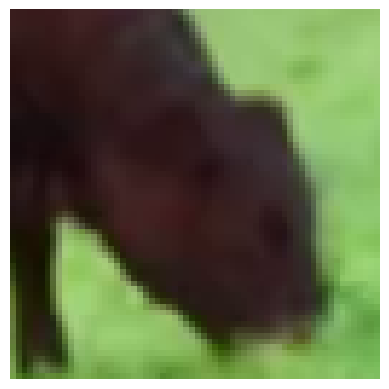

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal') 
ax.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))     
plt.grid(False)
plt.axis('off')
plt.show()

### First appearance model

For the particle filter, we need to define the data likelihood given a state $p(z|x^{(i)})$. We will explore two variants of appearance models. The first is based on the candidate patch to template Mean Squared Error. We will first simply compute the Mean Squared Error between the candidate patch (CP) color values and the template (T) color values: $$MSE = \frac{1}{NMC} \Vert CP - T \Vert_2^2 , $$

where $N,M$ are the patch dimensions and $C$ the number of color channels. We then take $\exp(-\frac{\lambda}{2} \cdot MSE)$ to obtain a value that is a probability (up to an unimportant multiplicative factor).

In [9]:
def mse_likelihood(image, template, bounding_boxes, lbda):
    """
    Evaluates the likelihood p(image|x_i) for x_i=bounding_boxes[i] for all i.
    The likelihood model is based on the patch-to-template Mean Square Error.
    
    Arguments:
    
    image: numpy.array((H,W,C))
    template: numpy.array((N,M,C))
    bounding_boxes: numpy.array((P,4)) where each row is in the format [x1,y1,x2,y2]
    lbda: real value or 1D numpy.array((L,))
    
    Returns: 1D numpy.array((P,)) if lbda is a scalar, numpy.array((L,P)) if lbda is a 1D array
        An array containing the likelihood values for each bounding box and each value of lbda.
    """
    
    # Extract patches delimited by bounding_boxes, where each
    # patch has the same dimensions as the template
    # Store them in a python list:
    patch_list = [extract_patch(image, bb) for bb in bounding_boxes]
    
    # Compute the mean squared error between patch and template intensities, for every patch in the patch_list.
    mse_list = [np.mean([mean_squared_error(patch[:,:,0], template[:,:,0]), mean_squared_error(patch[:,:,1], template[:,:,1]), mean_squared_error(patch[:,:,2], template[:,:,2])]) for patch in patch_list]
    mse = np.array(mse_list)
    
    # Compute the likelihood values and store them in a numpy array
    if np.isscalar(lbda):
        likelihoods = np.exp((-0.5*lbda)*mse)
    else:
        likelihoods = np.exp((-0.5)*(np.reshape(lbda, (-1, 1))@np.reshape(mse, (-1, 1)).T))
    
        
    return likelihoods

Let's visualize the likelihood map that we obtain for different lambda values. Each pixel value in this map represents the likelihood of a candidate patch centered at the given pixel (and of the same height and width as the template). The maps are subsampled by a factor of 10 for speed of execution.

As $\lambda$ gets larger, the map becomes more peaked around the actual template patch. For accurate object tracking, we will need maps that are quite peaked.

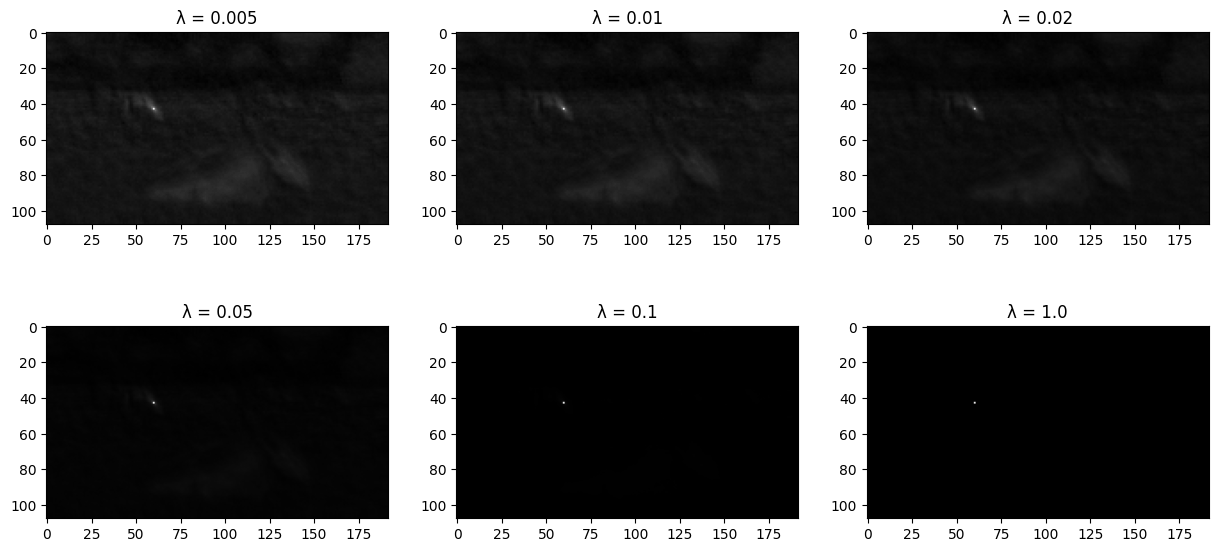

In [13]:
bbs = [np.array([x-template_W//2,y-template_H//2,
                 x+template_W//2,y+template_H//2,]) for y in np.arange(0, zeroth_frame.shape[0], 10) 
       for x in np.arange(0, zeroth_frame.shape[1], 10)]
bbs = np.array(bbs)

H_lik = zeroth_frame.shape[0]//10
W_lik = zeroth_frame.shape[1]//10
lbdas = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 1.])
likelihoods = mse_likelihood(zeroth_frame, template, bbs, lbdas)

fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(likelihoods[0,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 0].set_title('λ = {}'.format(lbdas[0]))
axs[0, 1].imshow(likelihoods[1,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 1].set_title('λ = {}'.format(lbdas[1]))
axs[0, 2].imshow(likelihoods[2,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 2].set_title('λ = {}'.format(lbdas[2]))
axs[1, 0].imshow(likelihoods[3,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 0].set_title('λ = {}'.format(lbdas[3]))
axs[1, 1].imshow(likelihoods[4,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 1].set_title('λ = {}'.format(lbdas[4]))
axs[1, 2].imshow(likelihoods[5,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 2].set_title('λ = {}'.format(lbdas[5]))
plt.show()

### Second appearance model

The second appearance model is based on a comparison of color histograms instead of a direct comparison of pixel values. We will first convert the patches from BGR (the default color space for opencv images) to HSV (Hue-Saturation-Value). We will then compute the joint histogram of the Hue (H) and Saturation (S) channels for the patch (discarding the information from the Value (V) channel, for reduced sensitivity to the lighting conditions). We discretize each channel to `n_bins` distinct values, resulting in an `n_bins`$\times$`n_bins` histogram.

By default, the histogram records the number of pixel values that fall in each bin. We will normalize it instead to record the probability of each bin (i.e., the sum of bin values should be normalized to 1).

Let's start by computing the histogram for the template patch:

In [39]:
n_bins = 10

# Convert to HSV then compute the Hue Saturation histogram
# Hints: You can use cv.cvtColor, cv.calcHist, cv.normalize instead of reimplementing these routines yourself
# We compute the histogram only based on the first two channels (Hue-Saturation). 
# The range of the hue channel is 0-179 included. The range of the saturation channel is 0-255 included.
template_hsv = cv.cvtColor(template, cv.COLOR_BGR2HSV) # template converted to HSV color space
template_hist = cv.calcHist([template_hsv], [0, 1], None, [n_bins, n_bins], [0,180] +[0,256])# normalized histogram
template_hist = cv.normalize(template_hist, template_hist, alpha=1., norm_type = cv.NORM_L1)

Now, let's define the data likelihood given a state $p(z|x^{(i)})$. The likelihood is based on the Bhattacharyya distance between normalized histograms as defined in slides 71-72.

In [43]:
def histogram_likelihood(image, template_hist, bounding_boxes, lbda):
    """
    Evaluates the likelihood p(image|x_i) for x_i=bounding_boxes[i] for all i.
    The likelihood model is based on a histogram Bhattacharyya distance.
    
    Arguments:
    
    image: numpy.array((H,W,C))
    template_hist: numpy.array((n_bins,n_bins)), the template histogram
    bounding_boxes: numpy.array((P,4)) where each row is in the format [x1,y1,x2,y2]
    lbda: real value or 1D numpy.array((L,))
    
    Returns: numpy.array((P,)) if lbda is a scalar, numpy.array((L,P)) if lbda is a 1D array
        An array containing the likelihood values for each bounding box and each value of lbda.
    """
    n_bins = template_hist.shape[0]
    
    # Extract patches delimited by bounding_boxes, where each
    # patch has dimensions N, M
    # Store them in a python list:
    patch_list = [extract_patch(image, bb) for bb in bounding_boxes]

    # Convert patches to HSV
    patch_list = [cv.cvtColor(patch, cv.COLOR_BGR2HSV) for patch in patch_list]
    
    # Compute histograms
    histogram_list = [cv.calcHist([patch], [0, 1], None, [n_bins, n_bins], [0,180] +[0,256]) for patch in patch_list]
    histogram_list = [cv.normalize(hist, hist, alpha=1., norm_type = cv.NORM_L1) for hist in histogram_list]
    
    # Compute the Bhattacharyya distance between patch and template histograms, for every patch in the patch_list.
    # Hint: you can use cv.compareHist rather than code the metric yourself
    distance_list = [cv.compareHist(template_hist, hist, cv.HISTCMP_BHATTACHARYYA) for hist in histogram_list]
    square_distances = np.array(distance_list)**2
    
    # Compute the likelihood values and store them in a 1D numpy array
    if np.isscalar(lbda):
        likelihoods = np.exp((-1*lbda)*square_distances)
    else:
        likelihoods = np.exp((-1)*(np.reshape(lbda, (-1, 1))@np.reshape(square_distances, (-1, 1)).T))
           
    return likelihoods

Let's visualize the likelihood maps that we obtain for different lambda values. They are quite different at low lambda values from the ones we obtained previously. For accurate object tracking, we will need the maps to be quite peaked.

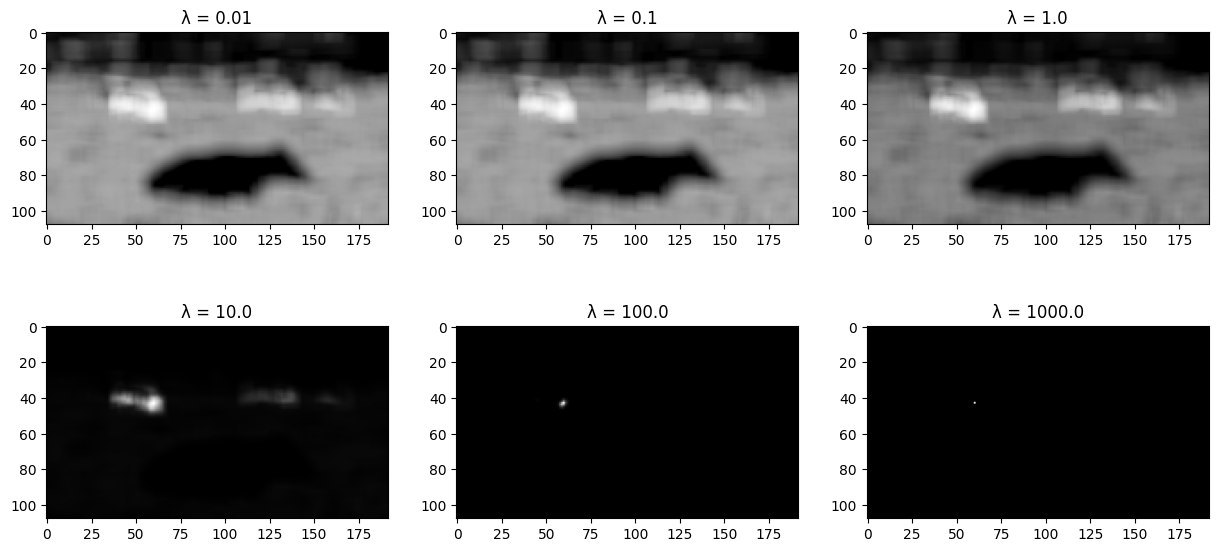

In [44]:
bbs = [np.array([x-template_W//2,y-template_H//2,
                 x+template_W//2,y+template_H//2,]) for y in np.arange(0, zeroth_frame.shape[0], 10) 
       for x in np.arange(0, zeroth_frame.shape[1], 10)]
bbs = np.array(bbs)

H_lik = zeroth_frame.shape[0]//10
W_lik = zeroth_frame.shape[1]//10
lbdas = np.array([0.01, 0.1, 1., 10., 100., 1e3])
likelihoods = histogram_likelihood(zeroth_frame, template_hist, bbs, lbdas)

fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(likelihoods[0,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 0].set_title('λ = {}'.format(lbdas[0]))
axs[0, 1].imshow(likelihoods[1,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 1].set_title('λ = {}'.format(lbdas[1]))
axs[0, 2].imshow(likelihoods[2,:].reshape((H_lik,W_lik)), cmap='gray')
axs[0, 2].set_title('λ = {}'.format(lbdas[2]))
axs[1, 0].imshow(likelihoods[3,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 0].set_title('λ = {}'.format(lbdas[3]))
axs[1, 1].imshow(likelihoods[4,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 1].set_title('λ = {}'.format(lbdas[4]))
axs[1, 2].imshow(likelihoods[5,:].reshape((H_lik,W_lik)), cmap='gray')
axs[1, 2].set_title('λ = {}'.format(lbdas[5]))
plt.show()

### Motion model

We will use a variant of the constant velocity motion model that is more reactive to changes in velocity. This variant is not a linear-Gaussian model, but this is not a problem for particle tracking!

The state (the particle) will consist of six values $[x,y,s,\dot{x},\dot{y},\dot{s}]$, where:
- $x$ is the coordinate along $x$-axis of the center of the candidate bounding box
- $y$ is the coordinate along $y$-axis of the center of the candidate bounding box
- $s$ is the "scale" of the bounding box. The scale parameter resizes the width and height of the candidate bounding box to $s$ times the width/height of the template bounding box *i.e*, $h=s\times$template_H and $w=s\times$template_W

The motion model / state propagation model is as follows.<br>
We first apply noise to the velocities: $\dot{x}_k=\dot{x}_{k-1}+\epsilon_{x}$, where $\epsilon_x \sim \mathcal{N}(0, \sigma_x^2)$; $\dot{y}_k=\dot{y}_{k-1}+\epsilon_{y}$, where $\epsilon_y \sim \mathcal{N}(0, \sigma_y^2)$; $\dot{s}_k=\dot{s}_{k-1}+\epsilon_{s}$, where $\epsilon_s \sim \mathcal{N}(0, \sigma_s^2)$.<br> 
We then compute the new $x,y,s$ based on the velocities, assuming the timestep is $\Delta t= 1$: $x_k=x_{k-1}+\dot{x}_k$, $y_k=y_{k-1}+\dot{y}_k$ and $s_k=s_{k-1}+\dot{s}_k$.

Let's implement this motion model / state propagation model:

In [45]:
def state_propagation(particles, process_noise_std=np.array([10.,10.,0.01])):
    """
    Apply the state propagation model to the particles.

    particles: numpy.array((n_particles, 6))
    
    Returns: numpy.array((n_particles, 6)), the updated particles
    """
    n_particles = particles.shape[0]
    
    # Create a generator for the multivariate normal distribution
    generator_x = np.random.default_rng().multivariate_normal(mean=np.zeros(n_particles), cov=process_noise_std[0]*np.eye(n_particles))
    generator_y = np.random.default_rng().multivariate_normal(mean=np.zeros(n_particles), cov=process_noise_std[1]*np.eye(n_particles))
    generator_s = np.random.default_rng().multivariate_normal(mean=np.zeros(n_particles), cov=process_noise_std[2]*np.eye(n_particles))
    
    new_speed_x = particles[:, 3] + generator_x
    new_speed_y = particles[:, 4] + generator_y
    new_speed_s = particles[:, 5] + generator_s
    
    return np.array([particles[:, 0] + new_speed_x, particles[:, 1] + new_speed_y, particles[:,2] + new_speed_s, new_speed_x, new_speed_y, new_speed_s]).T

In [72]:
def state_propagation(particles, process_noise_std=np.array([10.,10.,0.01])):
    """
    Apply the state propagation model to the particles.

    particles: numpy.array((n_particles, 6))
    
    Returns: numpy.array((n_particles, 6)), the updated particles
    """
    
    n_particles = particles.shape[0]
    
    # Generate process noise for each particle
    process_noise = np.random.randn(n_particles, 3) * process_noise_std

    # Update the velocities
    particles[:, 3:6] += process_noise

    # Update the positions and scale using the updated velocities (assuming timestep is 1)
    particles[:, 0:3] += particles[:, 3:6] 

    return particles

For compatibility between the motion and appearance models, we also need to implement a routine that computes bounding boxes in the format expected by the likelihood functions implemented above ([x1,y1,x2,y2] format) from the particles in the format $[x,y,s,\dot{x},\dot{y},\dot{s}]$:

In [12]:
def particles_to_bounding_boxes(particles):
    """
    Convert the format in which particles are written to the bounding box
    [x1,y1,x2,y2] format
    
    particles: numpy.array((n_particles, 6))
    
    Returns: numpy.array((n_particles, 4))
    """

    bounding_boxes = np.zeros((particles.shape[0], 4))
    bounding_boxes[:,0] = particles[:,0]-0.5*template_W*particles[:,2]
    bounding_boxes[:,1] = particles[:,1]-0.5*template_H*particles[:,2]
    bounding_boxes[:,2] = particles[:,0]+0.5*template_W*particles[:,2]
    bounding_boxes[:,3] = particles[:,1]+0.5*template_H*particles[:,2]
    
    return bounding_boxes

### Particle filter implementation

You will now implement the particle filter itself. Fill in the missing lines in the file `particle_filter.py`. The particle filter is completely generic with respect to the state propagation model and the likelihood model.

The actual state propagation model is passed at initialization time or at runtime as a function (argument `forward`) with signature `forward(particles)->particles`. (in the next section)

The actual likelihood model is passed at initialization time or at runtime as a function (argument `likelihood`) with signature `likelihood(particles, z)->likelihoods`. (in the next section)

### Running the single object tracker

Finally, you have to fill in the missing lines in the code implementing the particle filter-based single object tracker. You have to try the tracker with both appearance models and find suitable parameters each time (lambda, plus you can play with the process noise standard deviations). Is either appearance model more robust to the parameter settings, or yields better results?

The parts to complete are the following:
- the initialization: define the `forward` and `likelihood` functions that will be passed as arguments to initialize a `ParticleFilter`; initialize a `ParticleFilter` PF; initialize the particles of PF to a sensible value;
- the main loop: run the particle filter on each frame (we actually process only every 10th frame for speed reasons)

As the tracker is running, you will see the current frame being displayed with:
- all bounding boxes corresponding to the particles, in the first image displayed
- the bounding box corresponding to the mean state, in the second image displayed

The outputs of the code can be found in the folder 'output'. Frames with the overlayed bounding box of the tracked object are saved in the 'output/images folder'. A video is also made based on these frames and stored in 'output/video.avi'.

In [73]:
import os

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [74]:
from particle_filter import ParticleFilter

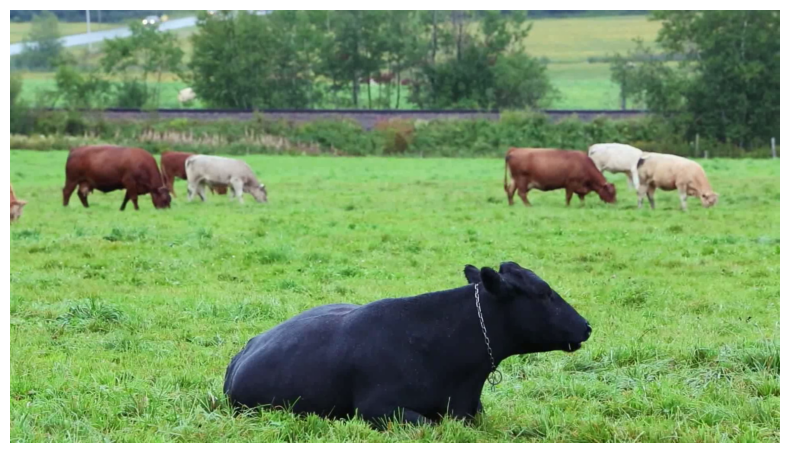

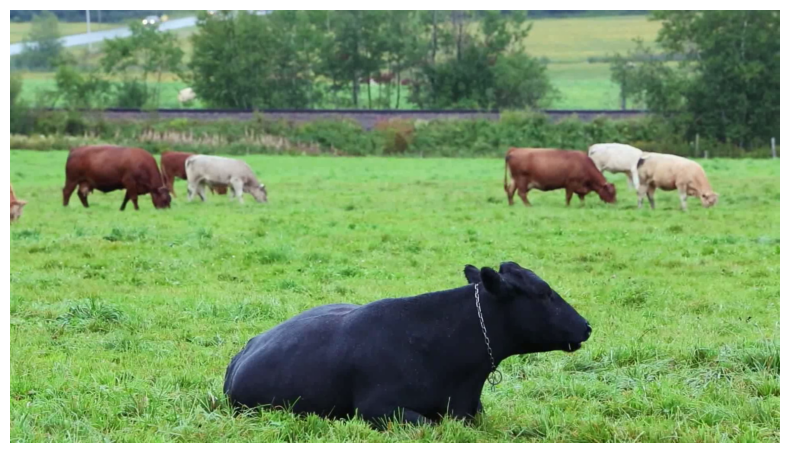

In [78]:
video_path = os.path.join('data', 'cows.avi')

colour_particle = np.array([1.,1.,0])
colour_mean = np.random.rand(1, 3)
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/images'):
    os.makedirs('output/images')

# Define likelihood and forward functions (cf. format expected in ParticleFilter)
# Hint: you can use lambda expressions to create functions based on xxx_likelihood and state_propagation 
# but with the correct arguments

forward = lambda particles: state_propagation(particles)
#likelihood = lambda particles, image: mse_likelihood(image, template, particles_to_bounding_boxes(particles), 0.2)
likelihood = lambda particles, frame: histogram_likelihood(frame, template_hist, particles_to_bounding_boxes(particles), 10, 10, 1000)

# Initialize particle filter
PF = ParticleFilter(6, tau=0.6, forward=forward, likelihood=likelihood)

# Initialize particle x, y, s values to match the template location and size
PF.particles[:,0] = template_x
PF.particles[:,1] = template_y 
PF.particles[:,2] = 1.

count = -1
video_capture = cv.VideoCapture(video_path)

while(True):
    # Read frame
    ret, frame = video_capture.read()
    if(frame is None): break
    
    # Run the particle filter
    count +=1
    if (count % 10) != 0:
        continue
    
    if count > 0: # ignore first template frame
        # Call ParticleFilter resample, predict and update routines:
        PF.resample()
        PF.predict(forward)
        PF.update(frame)

    
    # Compute the expectation of the state posterior
    mean_state = PF.state_expectation()
    mean_bb = particles_to_bounding_boxes(np.expand_dims(mean_state, axis=0))
    

    # Plot the frame with all particles' bounding boxes overlayed
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(10, 10*frame.shape[0]/frame.shape[1]))
    ax = fig.add_subplot(111, aspect='equal')   
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))   
    plt.grid(False)
    plt.axis('off')
    
    for d in particles_to_bounding_boxes(PF.particles):
        d = d.astype(np.int32)
        ax.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=1,ec=colour_particle))

    plt.show();
    
    # Plot and save frame with the mean state overlayed
    fig = plt.figure(figsize=(10, 10*frame.shape[0]/frame.shape[1]))
    ax = fig.add_subplot(111, aspect='equal')   
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))   
    plt.grid(False)
    plt.axis('off')
    
    d = mean_bb[0].astype(np.int32)
    ax.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colour_mean))

    plt.savefig(os.path.join('output', 'images', str(count).zfill(6) + '.png'))
    plt.show();

In [76]:
# Reload the png's and save as video for better visualization
image_folder = os.path.join('output', 'images')
video_name = os.path.join('output','video.avi')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv.imread(os.path.join(image_folder, image)))

cv.destroyAllWindows()
video.release()

# Tracking results on a second video

Let's test the approach on a second short clip of a presidential debate. This one is more difficult and the result will not be perfect. Try to find the model and parameters that make the tracking of the hand work as well as possible.

### First frame and template patch:

In [57]:
zeroth_frame_filename = os.path.join(data_dir, 'pres_debate_first_frame.png')
zeroth_frame = cv.imread(zeroth_frame_filename)

In [58]:
zeroth_frame.shape

(720, 1280, 3)

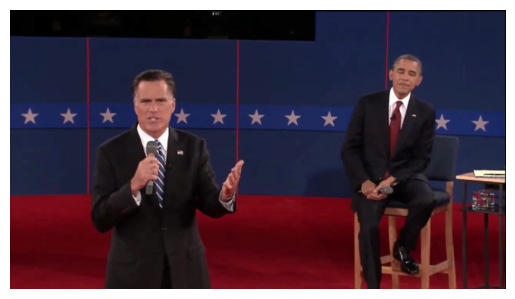

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal') 
ax.imshow(cv.cvtColor(zeroth_frame, cv.COLOR_BGR2RGB))     
plt.grid(False)
plt.axis('off')
plt.show()

In [60]:
# Template patch
template_W = 75
template_H = 75
template_x = 570
template_y = 440

# Bounding box in [x1,y1,x2,y2] format:
template_bb = np.array([template_x-template_W//2,template_y-template_H//2,
                        template_x+template_W//2,template_y+template_H//2])

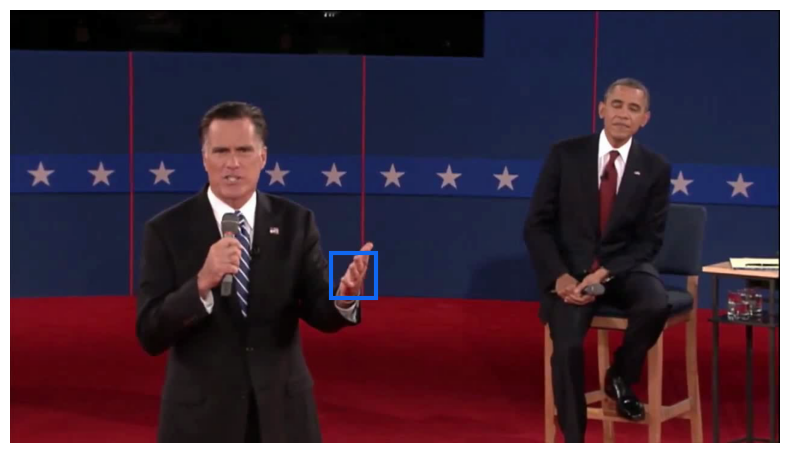

In [61]:
fig = plt.figure(figsize=(10, 10*zeroth_frame.shape[0]/zeroth_frame.shape[1]))
ax = fig.add_subplot(111, aspect='equal')   
ax.imshow(cv.cvtColor(zeroth_frame, cv.COLOR_BGR2RGB))   
plt.grid(False)
plt.axis('off')

d = np.array([template_x-template_W//2,template_y-template_H//2,template_W,template_H]).astype(np.int32)
ax.add_patch(patches.Rectangle((d[0],d[1]),d[2],d[3],fill=False,lw=3,ec=np.random.rand(1, 3)))
plt.show()

In [62]:
N = 64 # number of pixels in the patch along the x-axis
M = 64 # number of pixels in the patch along the y-axis 

# Extract the template patch
template = extract_patch(zeroth_frame, template_bb, N=N, M=M)

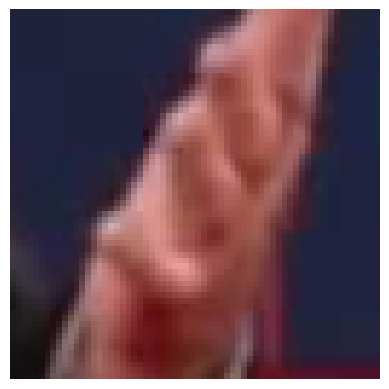

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal') 
ax.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))     
plt.grid(False)
plt.axis('off')
plt.show()

### Tracker

In [29]:
# Define the template histogram if you plan to use the histogram-based likelihood
n_bins = 10

template_hsv = xxxx
template_hist = xxxx

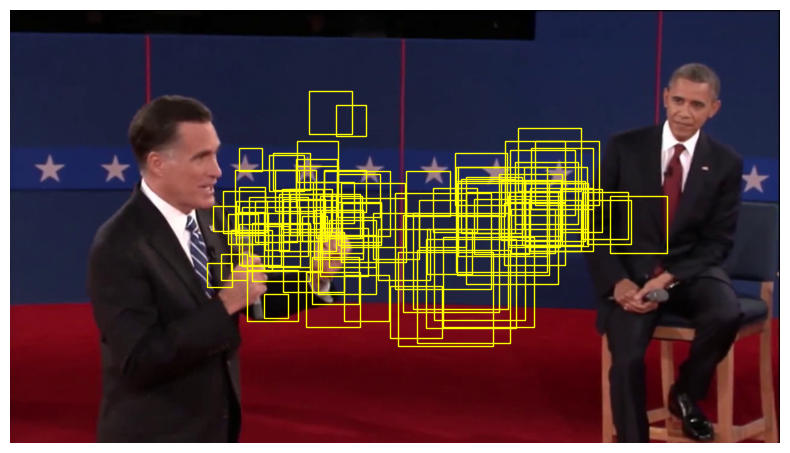

KeyboardInterrupt: 

In [64]:
video_path = os.path.join('data', 'pres_debate.avi')

colour_particle = np.array([1.,1.,0])
colour_mean = np.random.rand(1, 3)
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/images'):
    os.makedirs('output/images')

# Define forward and likelihood functions
forward = lambda particles: state_propagation(particles)
likelihood = lambda particles, frame: mse_likelihood(frame, template, particles_to_bounding_boxes(particles), 0.2)

# Initialize particle filter
PF = ParticleFilter(6, tau=0.8, forward=forward, likelihood=likelihood)

# Initialize particle x, y, s values to match the template location and size
PF.particles[:,0] = template_x
PF.particles[:,1] = template_y
PF.particles[:,2] = 1.

count = -1
video_capture = cv.VideoCapture(video_path)

while(True):
    # Read frame
    ret, frame = video_capture.read()
    if(frame is None): break
    
    # Run the particle filter
    count +=1
    if (count % 1) != 0:
        continue
    
    if count > 0: # ignore first template frame
        # Call ParticleFilter resample, predict and update routines:
        PF.resample()
        PF.predict() 
        PF.update(frame) 
        
    # Compute the expectation of the state posterior
    mean_state = PF.state_expectation()
    mean_bb = particles_to_bounding_boxes(np.expand_dims(mean_state, axis=0))
    
    # Plot the frame with all particles' bounding boxes overlayed
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(10, 10*frame.shape[0]/frame.shape[1]))
    ax = fig.add_subplot(111, aspect='equal')   
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))   
    plt.grid(False)
    plt.axis('off')
    
    for d in particles_to_bounding_boxes(PF.particles):
        d = d.astype(np.int32)
        ax.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=1,ec=colour_particle))

    plt.show();
    
    # Plot and save frame with the mean state overlayed
    fig = plt.figure(figsize=(10, 10*frame.shape[0]/frame.shape[1]))
    ax = fig.add_subplot(111, aspect='equal')   
    ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))   
    plt.grid(False)
    plt.axis('off')
    
    d = mean_bb[0].astype(np.int32)
    ax.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colour_mean))

    plt.savefig(os.path.join('output', 'images', str(count).zfill(6) + '.png'))
    plt.show();

In [114]:
# Reload the png's and save as video for better visualization
image_folder = os.path.join('output', 'images')
video_name = os.path.join('output','video.avi')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv.VideoWriter(video_name, 0, 30, (width,height))

for image in images:
    video.write(cv.imread(os.path.join(image_folder, image)))

cv.destroyAllWindows()
video.release()